# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

Throughout this project, I plan to import the data and take a preliminary look at it. After that, I will work on cleaning up data by removing or filling any null values, make sure the data types are appropriate for future analysis, and confirm the data is ready to go. 

Once I am ready to analyze, I may need to create some aggregate data to make sense of things, so we'll see when we get there. 

I will aggregate user data, study the plan conditions, study the user behavior for calls, messages and internet behavior, analyze revnue per user, and finally, test some statistical hypotheses with the data we've generated. 

Once we are finished with that, we can determine which plan is better for the company, and finalize our conclusions. 


Below is the data we are working with:

The **users** table (data on users):

    user_id — unique user identifier
    first_name — user's name
    last_name — user's last name
    age — user's age (years)
    reg_date — subscription date (dd, mm, yy)
    churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
    city — user's city of residence
    plan — calling plan name

The **calls** table (data on calls):

    id — unique call identifier
    call_date — call date
    duration — call duration (in minutes)
    user_id — the identifier of the user making the call

The **messages** table (data on texts):

    id — unique text message identifier
    message_date — text message date
    user_id — the identifier of the user sending the text

The **internet** table (data on web sessions):

    id — unique session identifier
    mb_used — the volume of data spent during the session (in megabytes)
    session_date — web session date
    user_id — user identifier

The **plans** table (data on the plans):

    plan_name — calling plan name
    usd_monthly_fee — monthly charge in US dollars
    minutes_included — monthly minute allowance
    messages_included — monthly text allowance
    mb_per_month_included — data volume allowance (in megabytes)
    usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
    usd_per_message — price per text after exceeding the package limits
    usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

[We've provided you with some commentary to guide your thinking as you complete this project. However, make sure to remove all the bracketed comments before submitting your project.]

[Before you dive into analyzing your data, explain for yourself the purpose of the project and actions you plan to take.]

[Please bear in mind that studying, amending, and analyzing data is an iterative process. It is normal to return to previous steps and correct/expand them to allow for further steps.]

## Initialization

In [1]:
# Loading all the libraries
# we will go ahead and import all of the libraries that I think I'll need
# We can always come back and remove the library if we don't use it

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math
import seaborn as sns



## Load data

In [2]:
# Load the data files into different DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')
print("calls")
calls.info()
print()

internet = pd.read_csv('/datasets/megaline_internet.csv')
print("internet")
internet.info()
print()

messages = pd.read_csv('/datasets/megaline_messages.csv')
print("messages")
messages.info()
print()

plans = pd.read_csv('/datasets/megaline_plans.csv')
print("plans")
plans.info()
print()

users = pd.read_csv('/datasets/megaline_users.csv')
print("users")
users.info()


calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

internet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

messages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column 

**Observations**
Initially looking at the tables here, I don't see any missing values. The only thing I see is 'churn_date' in `users`, and that makes sense to not have values in every row, unless every single customer in the sample had churned. 

I can see some data types that should be cleaned up, like 'call_date' in `calls` should be a datetime, 'session_date' in `internet` should be a datetime, etc. We will clean all of these up in the individual section for each table.

## Prepare the data

[The data for this project is split into several tables. Explore each one to get an initial understanding of the data. Do necessary corrections to each table if necessary.]

## Plans

In [3]:
# Print the general/summary information about the plans' DataFrame

plans.info()
print()
plans.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [4]:
# Print a sample of data for plans
# Plans data only has 2 records, full dataframe has been posted above. 


**Observations**

All of the plans data looks good to me. Data types are appropriate for each column, there is no missing data, and no duplicates. This should be good to move on. The thing that is strange, is that this table measures internet usage in mb, but the customers are charged per gb. We will likely want to fix this. 

## Fix data

Since the `plans` table is measuring internet usage in megabytes, but customers are charged in gigabytes, we will create a new column for gigabytes, preserving the initial data, but adding a new column for clarity's sake.

In [5]:
# We will take the value from 'mb_per_month_included' and divide it by 1024 to get the value in gb into a new column

plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024

display(plans.head())

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Enrich data

[Add additional factors to the data if you believe they might be useful.]

## Users

In [6]:
# Print the general/summary information about the users' DataFrame
users.info()
print()
users.head()

print("Duplicated rows:")
print(users.duplicated().sum())

print("Duplicated user IDs:")
print(users['user_id'].duplicated().sum())

print()
print("Number of users on each plan") # this may be helpful for later
print(users['plan'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Duplicated rows:
0
Duplicated user IDs:
0

Number of users on each plan
surf        339
ultimate    161
Name: plan, dtype: int64


In [7]:
# Print a sample of data for users
users.sample(5)



,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
468,1468,Johana,Kim,55,"Denver-Aurora-Lakewood, CO MSA",2018-09-08,surf,NaN
483,1483,Miguel,Farrell,35,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-25,surf,NaN
59,1059,Avril,Richardson,34,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-22,ultimate,NaN
36,1036,Myron,Hodge,70,"Denver-Aurora-Lakewood, CO MSA",2018-05-09,ultimate,NaN
385,1385,Nohemi,Erickson,52,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-19,surf,NaN


**Observations**

There are no duplicated rows nor user_ids. The only missing data looks to be 'churn_date', which makes sense, considering most customers probably haven't churned. Most data types look correct, but we'll want to change 'reg_date' and 'churn_date' to be datetimes, not objects, in case we want to do any specific datetime calculations. We may want to create an aggregate column to indicate if a customer has churned or not, perhaps a simple 1 or 0 to indicate, for any further calculations.

### Fix Data

[Fix obvious issues with the data given the initial observations.]

In [8]:
# We are going to convert the data types of 'reg_date' and 'churn_date' to be datetimes, instead of objects

users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# Lets check the data types for those columns to make sure it worked correctly

print("reg_date data type:", users['reg_date'].dtype)
print("churn_date data type:", users['churn_date'].dtype)

# Great, now let's check the users table to make sure it looks okay

display(users.sample(5))

# Everything looks okay, we can move on

reg_date data type: datetime64[ns]
churn_date data type: datetime64[ns]


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
284,1284,Yuri,Odom,51,"Dayton-Kettering, OH MSA",2018-09-07,surf,NaT
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaT
321,1321,Karlyn,Jimenez,19,"North Port-Sarasota-Bradenton, FL MSA",2018-05-31,surf,NaT
372,1372,Patria,Kim,26,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-10-08,surf,NaT
311,1311,Cherlyn,Saunders,69,"Memphis, TN-MS-AR MSA",2018-06-27,ultimate,NaT


### Enrich Data

We can use the existing data to add a new column to indicate whether or not a customer has churned

In [9]:
# We'll want to add a new column, called 'is_churned'
# We will generate the new column of True/False values using isna() to see if the 'churn_date' column is null

users['is_churned'] = users['churn_date'].isna()

# then we will use to_replace() and replace True values with 0 and False values with 1
# if isna() returns a True, that means there was no churn date, meaning the customer has not churned
users['is_churned'] = users['is_churned'].replace(to_replace=[True, False], value=[0, 1])



In [10]:
# checking samples to make sure the above code worked as expected
display(users.sample(10))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,is_churned
235,1235,Felton,Nguyen,50,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-02-20,surf,NaT,0
247,1247,Marion,Singleton,75,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-04-12,ultimate,NaT,0
256,1256,Johnny,Wise,53,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-09-11,surf,NaT,0
165,1165,Nigel,Huber,20,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-10-27,surf,NaT,0
438,1438,Harvey,Brooks,36,"Orlando-Kissimmee-Sanford, FL MSA",2018-06-15,surf,NaT,0
195,1195,Roy,Velez,60,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-06-09,surf,NaT,0
488,1488,Shirley,Jones,29,"Baton Rouge, LA MSA",2018-05-15,surf,NaT,0
136,1136,Jasper,Caldwell,25,"Knoxville, TN MSA",2018-10-14,surf,NaT,0
149,1149,Jamaal,Camacho,54,"San Francisco-Oakland-Berkeley, CA MSA",2018-03-03,surf,NaT,0
272,1272,Ernest,Mercado,23,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-08-04,surf,NaT,0


## Calls

In [11]:
# Print the general/summary information about the calls' DataFrame

calls.info()
print()
display(calls.head())

print("Duplicate rows:")
print(calls.duplicated().sum())
print("Duplicate ids:")
print(calls['id'].duplicated().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB



,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Duplicate rows:
0
Duplicate ids:
0


In [12]:
# Print a sample of data for calls

display(calls.sample(10))


,id,user_id,call_date,duration
64142,1232_438,1232,2018-04-10,12.78
132257,1476_198,1476,2018-12-19,8.53
38331,1144_221,1144,2018-09-22,13.60
112538,1397_98,1397,2018-12-29,10.09
99948,1358_357,1358,2018-08-18,4.68
105063,1370_153,1370,2018-11-26,0.00
46774,1170_536,1170,2018-10-22,0.00
103048,1365_244,1365,2018-10-29,7.40
38462,1144_369,1144,2018-07-08,1.42
132776,1478_230,1478,2018-11-30,1.61


**Observations**

There are no duplicate rows or call ids. This data looks mostly good, but we'll want to fix the data type for 'call_date' to a datetime. 'id' being an object shouldn't matter since it won't be used for calculations. 

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [13]:
# we will convert the 'call_date' to datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# checking the data type of the column
print(calls['call_date'].dtype)
# we'll check the table real quick to make sure the formatting looks correct
display(calls.head())

datetime64[ns]


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Enrich data

Since calls are rounded up to the minute, let's create a column with the call durations roudned up to the nearest minute

In [14]:
# using np.ceil() allows us to apply the ceiling function to the entire column
# which will round the decimal up to the next whole number, exactly what we want to achieve

calls['duration_rounded'] = np.ceil(calls['duration'])

display(calls.sample(10))


,id,user_id,call_date,duration,duration_rounded
74204,1263_188,1263,2018-11-12,0.00,0.0
103953,1366_162,1366,2018-10-22,8.13,9.0
104756,1368_475,1368,2018-06-04,8.08,9.0
700,1004_190,1004,2018-07-10,2.45,3.0
6597,1031_301,1031,2018-09-18,6.17,7.0
133416,1483_221,1483,2018-09-09,9.00,9.0
22998,1084_45,1084,2018-11-19,0.00,0.0
69753,1249_749,1249,2018-10-08,13.98,14.0
3876,1016_137,1016,2018-12-06,3.94,4.0
65638,1237_245,1237,2018-10-22,10.16,11.0


In [15]:
# Since we will be wanting to view call information on a per month basis
# perhaps it will make things easier to have a month column

# we'll use dt.month to grab just the month value from 'call_date' since it is a datetime now
calls['month'] = calls['call_date'].dt.month

display(calls.head())

,id,user_id,call_date,duration,duration_rounded,month
0,1000_93,1000,2018-12-27,8.52,9.0,12
1,1000_145,1000,2018-12-27,13.66,14.0,12
2,1000_247,1000,2018-12-27,14.48,15.0,12
3,1000_309,1000,2018-12-28,5.76,6.0,12
4,1000_380,1000,2018-12-30,4.22,5.0,12


## Messages

In [16]:
# Print the general/summary information about the messages' DataFrame

messages.info()
print()
display(messages.head())

print("Duplicated rows:")
print(messages.duplicated().sum())
print("Duplicated ids:")
print(messages['id'].duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB



,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Duplicated rows:
0
Duplicated ids:
0


In [17]:
# Print a sample of data for messages

display(messages.sample(5))

,id,user_id,message_date
53820,1341_96,1341,2018-12-19
15606,1102_15,1102,2018-12-24
10267,1076_615,1076,2018-08-03
43233,1285_55,1285,2018-08-21
13357,1088_365,1088,2018-12-01


**Observations**

There are no duplicate rows or ids. Most of this data looks okay too. We'll just want to fix the data type of the 'message_date' from an object to a datetime.

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [18]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d') 

# checking the data type of 'message_date'

print(messages['message_date'].dtype) 

# checking a sample to make sure the format 

display(messages.sample(5))

datetime64[ns]


,id,user_id,message_date
60821,1382_585,1382,2018-11-24
56514,1357_140,1357,2018-08-02
51080,1331_255,1331,2018-12-07
9256,1067_127,1067,2018-12-24
14881,1100_203,1100,2018-09-27


### Enrich data

We'll want to add a month column like we did for calls, for easier future analyses

In [19]:
# we'll use dt.month to grab just the month value from 'message_date' since it is a datetime now
messages['month'] = messages['message_date'].dt.month

display(messages.head())

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


**Observations**

`messages` should be ready to move forward. This is a simple table, I can't think of any enrichments that could be made to make our life easier later.

## Internet

In [20]:
# Print the general/summary information about the internet DataFrame

internet.info()
print()
display(internet.head())

print("Duplicate rows:")
print(internet.duplicated().sum())
print("Duplicate IDs:")
print(internet['id'].duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB



,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Duplicate rows:
0
Duplicate IDs:
0


In [21]:
# Print a sample of data for the internet traffic
display(internet.sample(5))


,id,user_id,session_date,mb_used
74933,1353_96,1353,2018-12-13,322.50
90674,1417_339,1417,2018-11-24,707.61
33198,1150_219,1150,2018-09-27,645.81
76289,1358_517,1358,2018-10-13,642.62
42770,1189_388,1189,2018-10-04,594.58


**Observation**

No duplicates. As we've seen before, we'll want to change the data type of 'session_date' to a datetime for calculations in the future. 

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [22]:
# Changing data type of 'session_date' to be a datetime

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# checking the data type of 'session_date'
print(internet['session_date'].dtype)

# checking the format in a sample
display(internet.sample(5))

datetime64[ns]


,id,user_id,session_date,mb_used
79884,1373_163,1373,2018-12-15,885.94
27411,1127_46,1127,2018-07-03,412.52
4433,1027_261,1027,2018-11-13,355.00
68136,1318_3,1318,2018-12-17,386.31
88561,1408_280,1408,2018-12-31,697.99


### Enrich data

Since the plans will total up the megabytes used at the end up the month, and then round up to the next gigabyte, we don't need to create a similar column like we did in `plans`. 

However, we'll grab just the month from 'session_date' and put it in a new 'month' column, like above

In [23]:
# we'll use dt.month to grab just the month value from 'session_date' since it is a datetime now
internet['month'] = internet['session_date'].dt.month

display(internet.head())

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


**Observations**

`internet` should be ready to go here. 'session_date' was converted to a datetime, and we shouldn't need to do anything with converting the 'mb_used' to gb, since we add up all the sessions at the end up the month and then round to the nearest gb. 

## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

In [24]:
# Print out the plan conditions and make sure they are clear for you
display(plans)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [25]:
# Calculate the number of calls made by each user per month. Save the result.
calls_per_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='count').reset_index()

# renaming the pivot column to reflect the data we are showing
calls_per_month = calls_per_month.rename(columns={'duration':'calls_sum'})
display(calls_per_month.head())


,user_id,month,calls_sum
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [26]:
# Calculate the amount of minutes spent by each user per month. Save the result.
minutes_per_month = calls.pivot_table(index=['user_id', 'month'], values='duration_rounded', aggfunc='sum').reset_index()

# renaming the pivot column to reflect the data we are displaying
minutes_per_month = minutes_per_month.rename(columns={'duration_rounded':'call_minutes'})
display(minutes_per_month.head())


,user_id,month,call_minutes
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0


In [27]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()

# renaming the pivot column to reflect the data we are displaying
messages_per_month = messages_per_month.rename(columns={'id':'messages_sum'})
display(messages_per_month.head())


,user_id,month,messages_sum
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [28]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_traffic = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()

# since Megaline charges per gb, and rounds up to the nearest gb, let's create a new column
# and convert 'mb_used' to gb, and then round up

internet_traffic['gb_used'] = internet_traffic['mb_used'] / 1024


# now we will use np.ceil() to round to the nearest whole gb

internet_traffic['gb_rounded'] = np.ceil(internet_traffic['gb_used'])

display(internet_traffic.head())


,user_id,month,mb_used,gb_used,gb_rounded
0,1000,12,1901.47,1.856904,2.0
1,1001,8,6919.15,6.756982,7.0
2,1001,9,13314.82,13.002754,14.0
3,1001,10,22330.49,21.807119,22.0
4,1001,11,18504.30,18.070605,19.0


[Put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.]

In [29]:
# Merge the data for calls, minutes, messages, internet based on user_id and month

call_merge = calls_per_month.merge(minutes_per_month, how='outer', on=['user_id', 'month'])

messages_merge = call_merge.merge(messages_per_month, how='outer', on=['user_id', 'month'])

internet_merge = messages_merge.merge(internet_traffic, how='outer', on=['user_id', 'month'])

display(internet_merge)

,user_id,month,calls_sum,call_minutes,messages_sum,mb_used,gb_used,gb_rounded
0,1000,12,16.0,124.0,11.0,1901.47,1.856904,2.0
1,1001,8,27.0,182.0,30.0,6919.15,6.756982,7.0
2,1001,9,49.0,315.0,44.0,13314.82,13.002754,14.0
3,1001,10,65.0,393.0,53.0,22330.49,21.807119,22.0
4,1001,11,64.0,426.0,36.0,18504.30,18.070605,19.0
...,...,...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,13039.91,12.734287,13.0
2289,1361,5,NaN,NaN,2.0,1519.69,1.484072,2.0
2290,1482,10,NaN,NaN,2.0,NaN,NaN,NaN
2291,1108,12,NaN,NaN,NaN,233.17,0.227705,1.0


We have some null values, which makes sense considering some users may not have used a specific service during a month. We can just fill those with 0s, a value that technically makes sense, because there would be 0 calls, minutes, messages or GBs used during that month.

In [30]:
internet_merge = internet_merge.fillna(0)

display(internet_merge)

,user_id,month,calls_sum,call_minutes,messages_sum,mb_used,gb_used,gb_rounded
0,1000,12,16.0,124.0,11.0,1901.47,1.856904,2.0
1,1001,8,27.0,182.0,30.0,6919.15,6.756982,7.0
2,1001,9,49.0,315.0,44.0,13314.82,13.002754,14.0
3,1001,10,65.0,393.0,53.0,22330.49,21.807119,22.0
4,1001,11,64.0,426.0,36.0,18504.30,18.070605,19.0
...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13039.91,12.734287,13.0
2289,1361,5,0.0,0.0,2.0,1519.69,1.484072,2.0
2290,1482,10,0.0,0.0,2.0,0.00,0.000000,0.0
2291,1108,12,0.0,0.0,0.0,233.17,0.227705,1.0


In [31]:
# # Add the plan information

# we create a new DataFrame called merge_plan to get the values of 'user_id' and 'plan' from the users DataFrame
# This will let us merge with the existing DataFrame by having the 'user_id' ready
merge_plan = pd.DataFrame({
    'user_id':users['user_id'],
    'plan':users['plan']
})

# performing the merge on 'user_id' 
monthly_customer_data = internet_merge.merge(merge_plan, how='left', on='user_id')

# in order to get our data grouped nicely by 'user_id' and 'month', we reset the indexes of the 
# merged DataFrame to be 'user_id' and 'month'
monthly_customer_data = monthly_customer_data.set_index(['user_id', 'month'])

display(monthly_customer_data.head())



calls_sum  call_minutes  messages_sum   mb_used    gb_used  \
user_id month                                                               
1000    12          16.0         124.0          11.0   1901.47   1.856904   
1001    8           27.0         182.0          30.0   6919.15   6.756982   
        9           49.0         315.0          44.0  13314.82  13.002754   
        10          65.0         393.0          53.0  22330.49  21.807119   
        11          64.0         426.0          36.0  18504.30  18.070605   

               gb_rounded      plan  
user_id month                        
1000    12            2.0  ultimate  
1001    8             7.0      surf  
        9            14.0      surf  
        10           22.0      surf  
        11           19.0      surf

[Calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan). N.B. This might not be as trivial as just a couple of lines given the plan conditions! So, it's okay to spend some time on it.]

In [32]:
# Calculate the monthly revenue for each user
def calculate_revenue(row):
    # intializing all variables
    surf_base = 20 # base cost, in dollars
    surf_minutes = 500 # base minutes allowed
    surf_messages = 50 # base messages allowed
    surf_data = 15 # base data usage allowed, in gbs
    surf_minute_over = 0.03 # cost per minute over base, in dollars
    surf_message_over = 0.03 # cost per message over base, in dollars
    surf_data_over = 10 # cost per gb over base, in dollars
    
    ult_base = 70 # base cost, in dollars
    ult_minutes = 3000 # base minutes allowed
    ult_messages = 1000 # base messages allowed
    ult_data = 30 # base data usage allowed, in gbs
    ult_minute_over = 0.01 # cost per minute over base, in dollars
    ult_message_over = 0.01 # cost per message over base, in dollars
    ult_data_over = 7 # cost per gb over base, in dollars
    
    revenue = 0
    
    if(row['plan'] == 'surf'):
        # calculating total minutes used, then subtracting from base amout for cost of minutes
        charged_minutes = row['call_minutes'] - surf_minutes 
        if(charged_minutes > 0): # if charged_minutes > 0, we have overages. If < 0, we are within confines of the plan
            revenue += charged_minutes * surf_minute_over # if we have overage, we add the overage minutes times the rate
                                                          # and add those to the revenue variable
        charged_messages = row['messages_sum'] - surf_messages
        if(charged_messages > 0):
            revenue += charged_messages * surf_message_over
        charged_data = row['gb_rounded'] - surf_data
        if(charged_data > 0):
            revenue += charged_data * surf_data_over
        revenue += surf_base
    elif(row['plan'] == 'ultimate'):
        charged_minutes = row['call_minutes'] - ult_minutes 
        if(charged_minutes > 0):
            revenue += charged_minutes * ult_minute_over
        charged_messages = row['messages_sum'] - ult_messages
        if(charged_messages > 0):
            revenue += charged_messages * ult_message_over
        charged_data = row['gb_rounded'] - ult_data
        if(charged_data > 0):
            revenue += charged_data * ult_data_over
        revenue += ult_base
        
    return revenue

# we will create a new column in the monthly_customer_data table by applying the calculate_revenue function
# we will apply it with the axis=1 argument, because we want to apply it for each row
monthly_customer_data['monthly_revenue'] = monthly_customer_data.apply(calculate_revenue, axis=1)

display(monthly_customer_data.sample(10))

,,calls_sum,call_minutes,messages_sum,mb_used,gb_used,gb_rounded,plan,monthly_revenue
user_id,month,,,,,,,,
1196,2,78.0,519.0,23.0,20085.20,19.614453,20.0,ultimate,70.00
1462,11,47.0,340.0,73.0,8576.98,8.375957,9.0,ultimate,70.00
1044,11,50.0,317.0,37.0,24572.15,23.996240,24.0,surf,110.00
1246,4,104.0,699.0,19.0,26662.62,26.037715,27.0,ultimate,70.00
1339,11,1.0,10.0,74.0,3762.38,3.674199,4.0,surf,20.72
1370,11,100.0,575.0,20.0,13425.23,13.110576,14.0,ultimate,70.00
1203,3,6.0,40.0,3.0,1248.03,1.218779,2.0,surf,20.00
1391,12,63.0,431.0,32.0,17510.47,17.100068,18.0,ultimate,70.00
1117,7,57.0,446.0,0.0,17769.81,17.353330,18.0,surf,50.00


## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

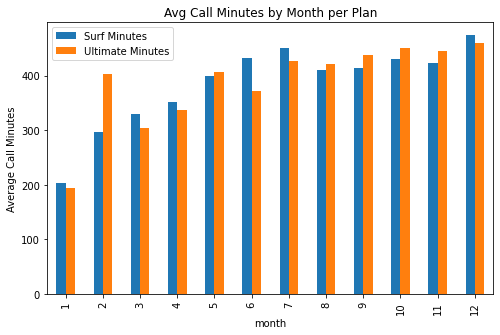

In [33]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

# creating new data sets for each plan, and resetting the index so we can work with it appropriately
surf_calls = monthly_customer_data.query("plan == 'surf'")
ult_calls = monthly_customer_data.query("plan == 'ultimate'")

# calculating average per plan per month, and converting to dataframe
avg_surf_calls = surf_calls.groupby('month')['call_minutes'].mean().to_frame()
avg_ult_calls = ult_calls.groupby('month')['call_minutes'].mean().to_frame()

# merging avg_surf and avg_ult into one dataframe avg_minutes to plot, and resetting the index
# so we have 'month' available
avg_minutes = avg_surf_calls.merge(avg_ult_calls, on='month').reset_index()

# renaming the columns after the merge so they make sense
avg_minutes = avg_minutes.rename(columns={'call_minutes_x': 'Surf Minutes', 'call_minutes_y': 'Ultimate Minutes'})

# creating the bar graph
avg_minutes.plot.bar(x='month', figsize=(8,5), title='Avg Call Minutes by Month per Plan')

plt.ylabel('Average Call Minutes')
plt.show()

**Observations**

In most cases, it seems that the average minute usage between Surf and Ultimate users is roughly the same. Without any biases, I was expecting Ultimate plan users to have a higher average of call minutes per month, just based on the higher plan price, suggesting that they were more frequent users of the services.

It doesn't look like the average Ultimate user is getting anywhere near the 3000 minute limit of the Ultimate plan. 

Perhaps the Ultimate users are getting their money's worth from other services of the plan?

In [34]:
monthly_customer_data_copy = monthly_customer_data.reset_index()

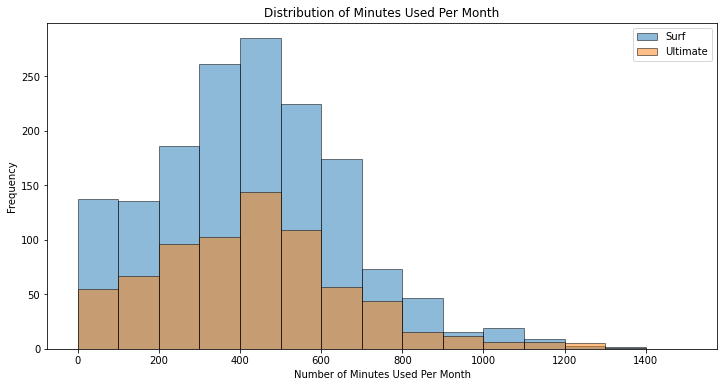

In [35]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

# Generating a new dataset to just have the minutes per month values for each user for each plan
surf_calls_minutes = monthly_customer_data_copy[monthly_customer_data_copy['plan'] == 'surf']['call_minutes']
surf_calls_minutes = surf_calls_minutes.reset_index(drop=True)

ult_calls_minutes = monthly_customer_data_copy[monthly_customer_data_copy['plan'] == 'ultimate']['call_minutes']
ult_calls_minutes = ult_calls_minutes.reset_index(drop=True)

surf_calls_minutes.plot(kind='hist',
                        title='Distribution of Minutes Used Per Month',
                        alpha=0.5,
                        bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500],
                        edgecolor='black',
                        figsize=(12, 6))
ult_calls_minutes.plot(kind='hist',
                       alpha=0.5,
                       bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500],
                       edgecolor='black')

plt.legend(['Surf', 'Ultimate'])
plt.xlabel('Number of Minutes Used Per Month')
plt.show()
                        

**Observations** 

From this distribution, we can estimate that both the Surf and Ultimate users are using around 400 minutes of calls per month. There are certainly more Surf users compared to Ultimate users, but the overall distribution of how long they are spending in calls doesn't seem to be very different at all.

[Calculate the mean and the variable of the call duration to reason on whether users on the different plans have different behaviours for their calls.]

In [36]:
# Calculate the mean and the variance of the monthly call duration

surf_var_calls = np.var(surf_calls_minutes)
ult_var_calls = np.var(ult_calls_minutes)

print("surf_var_calls =", surf_var_calls, " || ult_var_calls =", ult_var_calls)

surf_mean_calls = surf_calls_minutes.mean()
ult_mean_calls = ult_calls_minutes.mean()

print("surf_mean_calls =", surf_mean_calls, " || ult_mean_calls =", ult_mean_calls)


surf_var_calls = 54933.334591317485  || ult_var_calls = 57764.12527777777
surf_mean_calls = 428.7495232040687  || ult_mean_calls = 430.45


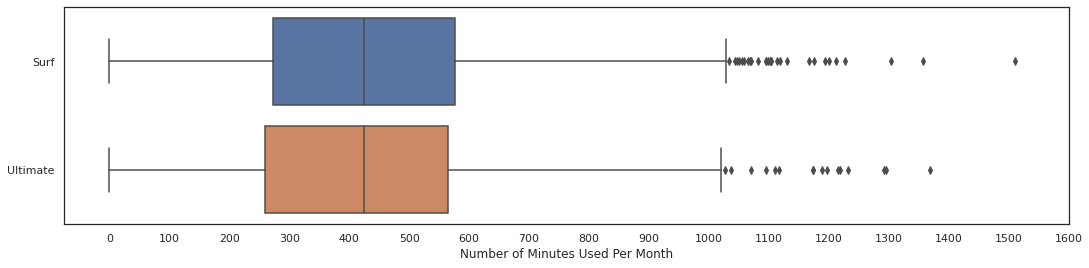

In [37]:
# Plot a boxplot to visualize the distribution of the monthly call duration

# plt.boxplot([surf_calls_minutes, ult_calls_minutes], labels=['Surf', 'Ultimate'], vert=False)
sns.set(rc={'figure.figsize':(18, 4)}, style='white')
sns.boxplot(data=[surf_calls_minutes, ult_calls_minutes],
            orient='h').set(xlabel='Number of Minutes Used Per Month')


plt.xticks(np.arange(0, 1700, step=100))
plt.yticks([0,1], labels=['Surf', 'Ultimate'])
plt.show()

**Observations**

Seeing the boxplot distribution, we can safely conclude that the behaviors of users between the two plan types are quite similar. Means are almost the same, quartiles are nearly the same, and the range is nearly the same. Surf seems to have more outliers, which could also just be from there being more data from Surf users. 

### Messages

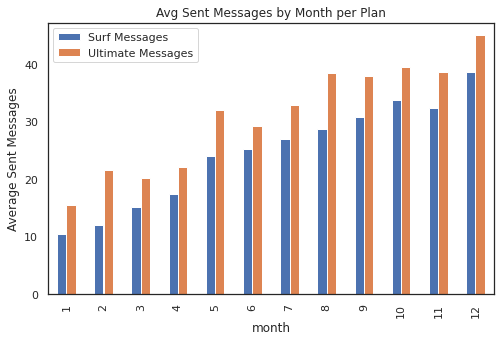

In [38]:
# Compare the number of messages users of each plan tend to send each month

# creating new data sets for each plan, and resetting the index so we can work with it appropriately
surf_messages = monthly_customer_data.query("plan == 'surf'")
ult_messages = monthly_customer_data.query("plan == 'ultimate'")

# calculating average per plan per month, and converting to dataframe
avg_surf_messages = surf_messages.groupby('month')['messages_sum'].mean().to_frame()
avg_ult_messages = ult_messages.groupby('month')['messages_sum'].mean().to_frame()

# merging avg_surf_messages and avg_ult_messages into one dataframe avg_messages to plot, and resetting the index
# so we have 'month' available
avg_messages = avg_surf_messages.merge(avg_ult_messages, on='month').reset_index()

# renaming the columns after the merge so they make sense
avg_messages = avg_messages.rename(columns={'messages_sum_x': 'Surf Messages', 'messages_sum_y': 'Ultimate Messages'})

# creating the bar graph
avg_messages.plot.bar(x='month', figsize=(8,5), title='Avg Sent Messages by Month per Plan')

plt.ylabel('Average Sent Messages')
plt.show()

**Observations**

Here, we can see a distinct difference in the average messages per plan type. Unlike the call minutes where things were quite similar, Ultimate users have a higher average message count for every single month. This may be where users are getting their money's worth by paying for Ultimate.

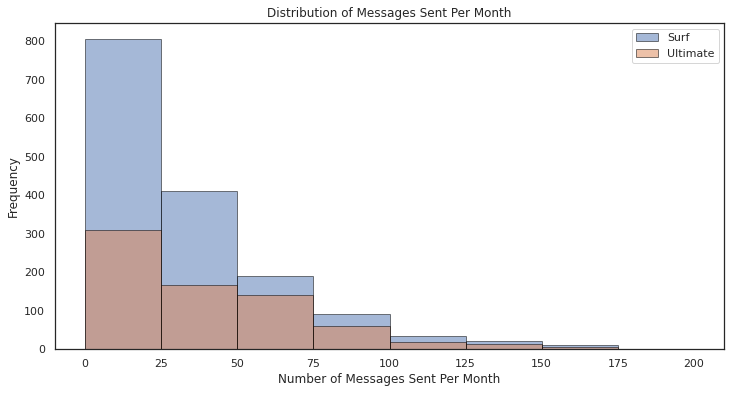

In [39]:
# Compare the number of messages users of each plan require each month. Plot a histogram.

# Generating a new dataset to just have the minutes per month values for each user for each plan
surf_message_dist = monthly_customer_data_copy[monthly_customer_data_copy['plan'] == 'surf']['messages_sum']
surf_message_dist = surf_message_dist.reset_index(drop=True)

ult_message_dist = monthly_customer_data_copy[monthly_customer_data_copy['plan'] == 'ultimate']['messages_sum']
ult_message_dist = ult_message_dist.reset_index(drop=True)


surf_message_dist.plot(kind='hist',
                        title='Distribution of Messages Sent Per Month',
                        alpha=0.5,
                        bins=[0, 25, 50, 75, 100, 125, 150, 175, 200],
                        edgecolor='black',
                        figsize=(12, 6))
ult_message_dist.plot(kind='hist',
                        alpha=0.5,
                        bins=[0, 25, 50, 75, 100, 125, 150, 175, 200],
                        edgecolor='black')

plt.legend(['Surf', 'Ultimate'])
plt.xlabel('Number of Messages Sent Per Month')
plt.show()
                        


In [40]:
# Calculate the mean and the variance of the monthly call duration
surf_var_messages = np.var(surf_message_dist)
surf_mean_messages = surf_message_dist.mean()

ult_var_messages = np.var(ult_message_dist)
ult_mean_messages = ult_message_dist.mean()

print("surf_mean_messages =", surf_mean_messages, " || ult_mean_messages =", ult_mean_messages)
print("surf_var_messages =", surf_var_messages, " || ult_var_messages =", ult_var_messages)


surf_mean_messages = 31.15956770502225  || ult_mean_messages = 37.55138888888889
surf_var_messages = 1126.008231726662  || ult_var_messages = 1207.0779147376545


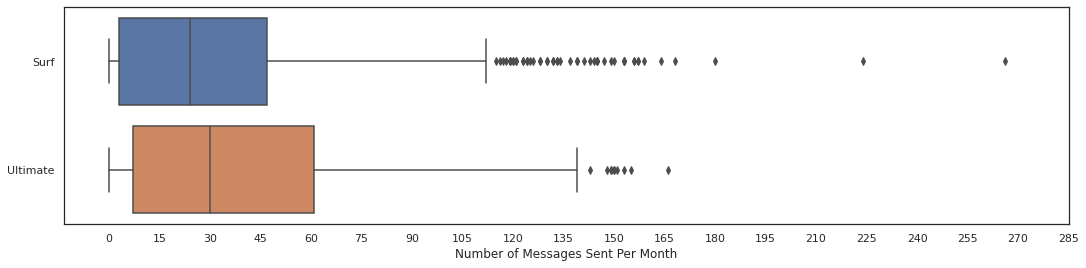

In [41]:
# Plot a boxplot to visualize the distribution of the monthly call duration

sns.set(rc={'figure.figsize':(18, 4)}, style='white')
sns.boxplot(data=[surf_message_dist, ult_message_dist],
            orient='h').set(xlabel='Number of Messages Sent Per Month')


plt.xticks(np.arange(0, 300, step=15))
plt.yticks([0,1], labels=['Surf', 'Ultimate'])
plt.show()

**Observations**

We can see the clear pattern that the Ultimate users are more frequently sending messages, and more of them. The average messages per month is higher for Ultimate users every month. Where the distribution of messages sent per Surf users quickly drops off at around 50 according to the histogram, Ultimate users continue to send more, until they taper off more towards the 75/100 message range. 

Looking at the mean and boxplot continues to tell the same story. Ultimate users are sending more messages than their Surf user counterparts. 

### Internet

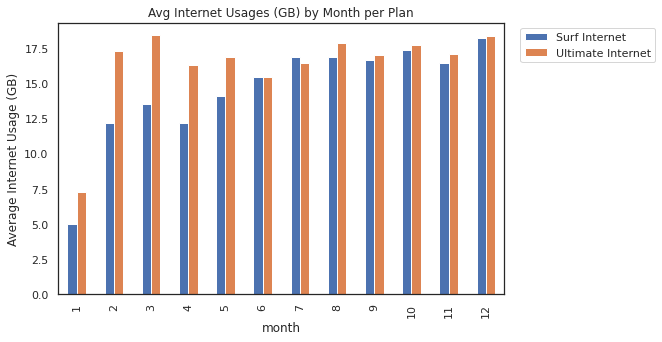

In [42]:
# Compare the amount of internet traffic consumed by users per plan

# creating new data sets for each plan, and resetting the index so we can work with it appropriately
surf_internet = monthly_customer_data.query("plan == 'surf'")
ult_internet = monthly_customer_data.query("plan == 'ultimate'")

# calculating average per plan per month, and converting to dataframe
avg_surf_internet = surf_internet.groupby('month')['gb_rounded'].mean().to_frame()
avg_ult_internet = ult_internet.groupby('month')['gb_rounded'].mean().to_frame()

# merging avg_surf_messages and avg_ult_messages into one dataframe avg_messages to plot, and resetting the index
# so we have 'month' available
avg_internet = avg_surf_internet.merge(avg_ult_internet, on='month').reset_index()

# renaming the columns after the merge so they make sense
avg_internet = avg_internet.rename(columns={'gb_rounded_x': 'Surf Internet', 'gb_rounded_y': 'Ultimate Internet'})

# creating the bar graph
avg_internet.plot.bar(x='month', figsize=(8,5), title='Avg Internet Usages (GB) by Month per Plan')

plt.legend(bbox_to_anchor=(1.35, 1.0), loc='upper right')
plt.ylabel('Average Internet Usage (GB)')
plt.show()

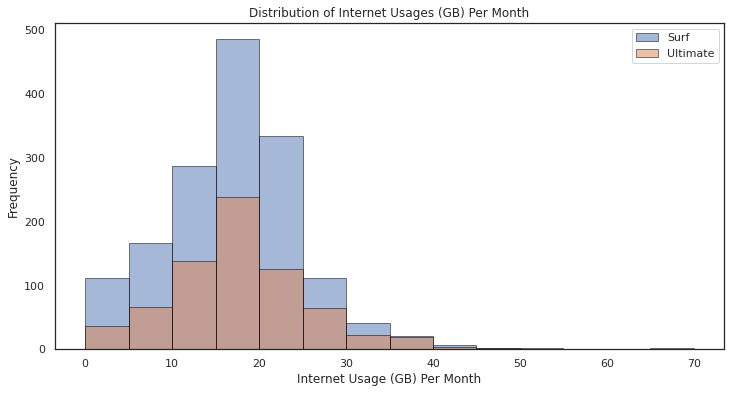

In [43]:
# Compare the number of messages users of each plan require each month. Plot a histogram.

# Generating a new dataset to just have the minutes per month values for each user for each plan
surf_internet_dist = monthly_customer_data_copy[monthly_customer_data_copy['plan'] == 'surf']['gb_rounded']
surf_internet_dist = surf_internet_dist.reset_index(drop=True)

ult_internet_dist = monthly_customer_data_copy[monthly_customer_data_copy['plan'] == 'ultimate']['gb_rounded']
ult_internet_dist = ult_internet_dist.reset_index(drop=True)


surf_internet_dist.plot(kind='hist',
                        title='Distribution of Internet Usages (GB) Per Month',
                        alpha=0.5,
                        bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
                        edgecolor='black',
                        figsize=(12, 6))
ult_internet_dist.plot(kind='hist',
                        alpha=0.5,
                        bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
                        edgecolor='black')

plt.legend(['Surf', 'Ultimate'])
plt.xlabel('Internet Usage (GB) Per Month')
plt.show()
                        


In [44]:
# Calculate the mean and the variance of the monthly call duration
surf_var_internet = np.var(surf_internet_dist)
surf_mean_internet = surf_internet_dist.mean()

ult_var_internet = np.var(ult_internet_dist)
ult_mean_internet = ult_internet_dist.mean()

print("surf_mean_internet =", surf_mean_internet, " || ult_mean_internet =", ult_mean_internet)
print("surf_var_internet =", surf_var_internet, " || ult_var_internet =", ult_var_internet)


surf_mean_internet = 16.670692943420217  || ult_mean_internet = 17.306944444444444
surf_var_internet = 61.54444942447023  || ult_var_internet = 58.748840663580246


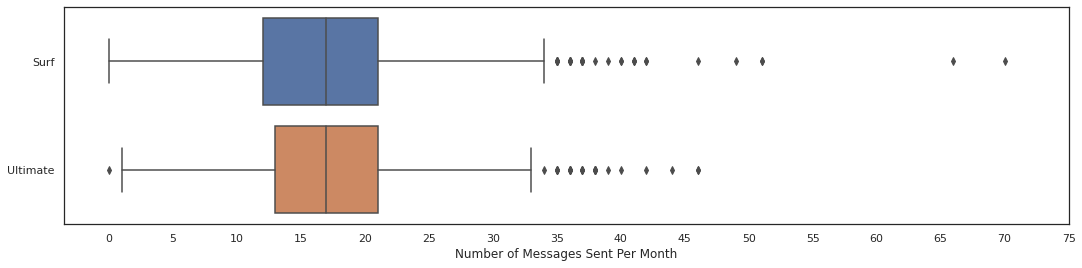

In [45]:
# Plot a boxplot to visualize the distribution of the monthly call duration

sns.set(rc={'figure.figsize':(18, 4)}, style='white')
sns.boxplot(data=[surf_internet_dist, ult_internet_dist],
            orient='h').set(xlabel='Number of Messages Sent Per Month')


plt.xticks(np.arange(0, 80, step=5))
plt.yticks([0,1], labels=['Surf', 'Ultimate'])
plt.show()

**Observations**

The data is not supporting a conclusion on whether Ultimate or Surf customers are using more data than the other plan type. We can see a slight advantage to Ultimate users in average GB usage in the earlier months, but it evens out as the year advances. The distribution of internet usage between the two plans seems quite similar. 

When we look at the mean, Ultimate users have a slight edge of 0.7 GB over Surf users, but it's not a large difference. Looking at the box plot, we can see the same story that the rest of the data told -- these figures are roughly the same between the two Plan types. 

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

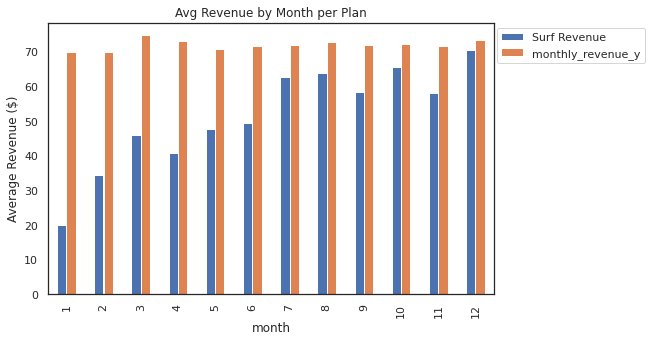

In [46]:
# Compare the revenue of users per plan

# creating new data sets for each plan, and resetting the index so we can work with it appropriately
surf_revenue = monthly_customer_data.query("plan == 'surf'")
ult_revenue = monthly_customer_data.query("plan == 'ultimate'")

# calculating average per plan per month, and converting to dataframe
avg_surf_revenue = surf_revenue.groupby('month')['monthly_revenue'].mean().to_frame()
avg_ult_revenue = ult_revenue.groupby('month')['monthly_revenue'].mean().to_frame()

# merging avg_surf_messages and avg_ult_messages into one dataframe avg_messages to plot, and resetting the index
# so we have 'month' available
avg_revenue = avg_surf_revenue.merge(avg_ult_revenue, on='month').reset_index()

# renaming the columns after the merge so they make sense
avg_revenue = avg_revenue.rename(columns={'monthly_revenue_x': 'Surf Revenue', 'monthly_revenue': 'Ultimate Revenue'})

# creating the bar graph
avg_revenue.plot.bar(x='month', figsize=(8,5), title='Avg Revenue by Month per Plan')

plt.legend(bbox_to_anchor=(1.35, 1.0), loc='upper right')
plt.ylabel('Average Revenue ($)')
plt.show()

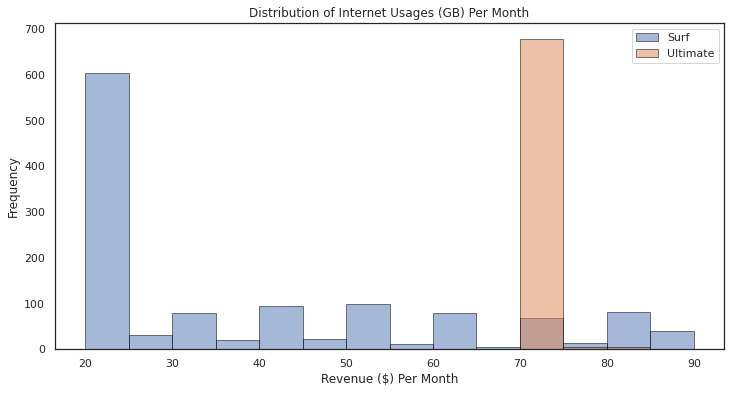

In [47]:
# Compare the number of messages users of each plan require each month. Plot a histogram.

# Generating a new dataset to just have the minutes per month values for each user for each plan
surf_revenue_dist = monthly_customer_data_copy[monthly_customer_data_copy['plan'] == 'surf']['monthly_revenue']
surf_revenue_dist = surf_revenue_dist.reset_index(drop=True)

ult_revenue_dist = monthly_customer_data_copy[monthly_customer_data_copy['plan'] == 'ultimate']['monthly_revenue']
ult_revenue_dist = ult_revenue_dist.reset_index(drop=True)


surf_revenue_dist.plot(kind='hist',
                        title='Distribution of Internet Usages (GB) Per Month',
                        alpha=0.5,
                        bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
                        edgecolor='black',
                        figsize=(12, 6))
ult_revenue_dist.plot(kind='hist',
                        alpha=0.5,
                        bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
                        edgecolor='black')

plt.legend(['Surf', 'Ultimate'])
plt.xlabel('Revenue ($) Per Month')
plt.show()
                        


In [48]:
# Calculate the mean and the variance of the monthly call duration
surf_var_revenue = np.var(surf_revenue_dist)
surf_mean_revenue = surf_revenue_dist.mean()

ult_var_revenue = np.var(ult_revenue_dist)
ult_mean_revenue = ult_revenue_dist.mean()

print("surf_mean_revenue =", surf_mean_revenue, " || ult_mean_revenue =", ult_mean_revenue)
print("surf_var_revenue =", surf_var_revenue, " || ult_var_revenue =", ult_var_revenue)


surf_mean_revenue = 60.706408137317226  || ult_mean_revenue = 72.31388888888888
surf_var_revenue = 3065.8848438690247  || ult_var_revenue = 129.66814043209877


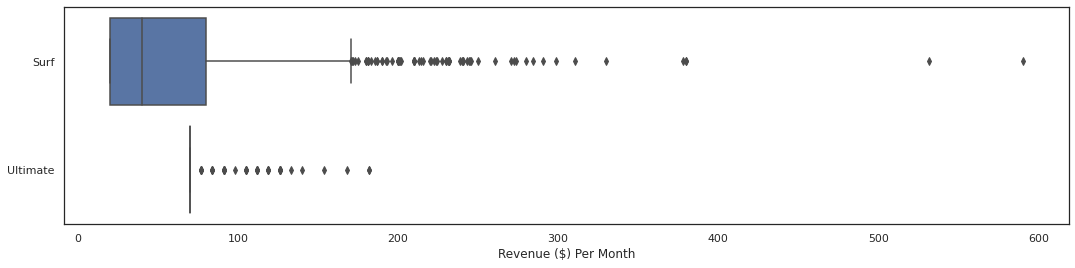

In [49]:
# Plot a boxplot to visualize the distribution of the monthly call duration

sns.set(rc={'figure.figsize':(18, 4)}, style='white')
sns.boxplot(data=[surf_revenue_dist, ult_revenue_dist],
            orient='h').set(xlabel='Revenue ($) Per Month')


plt.yticks([0,1], labels=['Surf', 'Ultimate'])
plt.show()

**Observations** 

When looking at this data from a revenue standpoint, we can likely interpret that the most consistent money-maker is the Ultimate plan. It has higher average revenue per month for every month of the year. Its mean is \$12 higher than the Surf plan, and its variance (and ultimately, standard deviation) is incredibly low, proving its consistency. 

One thing to note, it is very rare that customers use more than the allotted services under the Ultimate plan, so most customers end up generating right around \$70 per month, and not more. 

The Surf plan has a few crazy high outliers, with a couple of them between the $500-600 range.

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [50]:
# Test the hypotheses

# The null hypothesis will be that the average revenue between users of Ultimate and Surf plans are the same
# The alternative hypothesis will be that the average revenue between users of Ultimate and Surf plans are different

# We will be using scipy.stats.ttest_ind to test the two samples for any statistically significant differences

surf_users = monthly_customer_data.query("plan == 'surf'")['monthly_revenue']
ult_users = monthly_customer_data.query("plan == 'ultimate'")['monthly_revenue']

alpha = 0.05 # setting our critical statistical significance level

# test the hypothesis that the means of the two independent populations are equal
results = st.ttest_ind(surf_users, ult_users, equal_var=False) 

print('p-value:', results.pvalue) 

# compare the p-value you get with the significance level
if (results.pvalue < alpha): 
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")


p-value: 3.17039054811355e-15
We reject the null hypothesis


**Observations**

Since we have rejected the null hypothesis, we now know that the mean revenue values between the Ultimate and Surf plans are in fact different. 

[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [51]:
# Test the hypotheses

# The null hypothesis will be that the avg revenue from NY-NJ users is not different than those of other regions
# The alternate hypothesis will be that the avg revenue from NY-NJ users is different than those of other regions

# first we need to add the region info to our monthly_customer_data DataFrame

users_region = pd.DataFrame({
    'user_id': users['user_id'],
    'region': users['city']
})

# Now we will merge users_region into monthly_customer_data

monthly_customer_data = monthly_customer_data.merge(users_region, how='left', on='user_id')

# Creating our samples for testing
ny_nj_region = monthly_customer_data[monthly_customer_data['region'].str.contains('NY-NJ', regex=False)]['monthly_revenue']
other_region = monthly_customer_data[~monthly_customer_data['region'].str.contains('NY-NJ', regex=False)]['monthly_revenue']


alpha = 0.05 # setting our critical statistical significance level

# testing the hypothesis that the means are equal 
results_test_2 = st.ttest_ind(ny_nj_region, other_region, equal_var=False)

print('p-value:', results_test_2.pvalue)

if (results.pvalue < alpha): 
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.03352561588530014
We reject the null hypothesis


**Observations** 

We have rejected the null hypothesis that the average revenue of the NY-NJ region is not different than the average revenue from other regions. This does not mean we can confirm it is higher or lower, but there is not evidence to support the claim that it is the same. 

## General conclusion

[List your important conclusions in this final section, make sure they cover all those important decisions (assumptions) that you've made and that led you to the way you processed and analyzed the data.]

Throughout this project, we heavily dove into some data for the Megaline company, and how their customers use their services. We first analyzed the calls that each user made. We discovered that on average, both Surf and Ultimate customers had roughly the same amount of minutes used per month. When we looked into the minute distribution with a histogram and boxplot, the same story was told: there is not a significant difference between Surf users and Ultimate users, when we are talking about calls.

Moving into messages, we began to see where the Ultimate users were pulling ahead. Every single month, Ultimate users averaged more messages sent than Surf users. When we looked at the distribution on the histogram, there was a steep decline in occurrences of Surf users having more than 50 messages. A similar level of delice was not noticed for Ultimate users until between the 75-100 message point. The mean of Ultimate messages was 37.5, where it was 31.2 for the Surf users. The Surf user average is almost 17% less than the Ultimate users, which is pretty significant. The boxplot shows the same, but does have a considerable amount of outliers for the Surf plan.

When we look at the internet usage, we are seeing a similar outcome of the calls data. Between the averages per month, distributions, and mean values, we aren't able to discern any key differences between the two plans. Internet usages between Surf and Ultimate users is roughly the same.

Moving on to the revenue, we saw that the average monthly revenue was higher for the Ultimate customers for every single month of the year. The largest majority of Surf users paid the plan price only of 20, and an overwhelming majority of Ultimate users paid the plan price of 70 and nothing extra. Looking at the mean values, the mean revenue for Ultimate users was 72.31, and 60.71 for Surf users. The variance for Ultimate users was only 129.67, which paints a picture of very little fluctuation in the amount that Ultimate users pay. Variance for Surf was 3065.89, which is pretty supported by the rest of the data, seeing all the outliers combined with the very low allowance of services for Surf users. 

We were able to reject the null hypothesis that the average revenue between plans was the same. That doesn't tell us which is the better plan though. But we have enough data to at least make an educated guess here. 

In our sample of 500 customers, we have 339 users on the Surf plan and 161 users on the Ultimate plan. We know the mean monthly revenue per plan type, so that gives us:

339 Surf users x 60.71 (average revenue per month for Surf) = 20,580.69 average, per month

161 Ultimate users x 72.31 (average revenue per month for Ultimate) = 11,641.91 average, per month

If we are looking strictly at averages, the Surf plan tends to make the company more money. I think this makes sense. The Surf plan has very low allowances and higher premiums for additional services over the limit. Its low cost of entry is relying on customers using up their allowances of services, and needing to pay that higher premium when they go over. 

The Ultimate plan has a much higher cost of entry, but gives users the freedom to use (almost) as much as they want without having to pay extra. We can see this in action because the average revenue per Ultimate user is 72.31, which is just 2 over the plan cost of 70, where the average revenue for Surf is 60.71, which is a whopping 40 over the plan cost of 20. 

As long as customers continue to purchase the Surf plan with its low cost of entry and high premiums for extras, I believe it will continue to be the higher revenue generating plan.